In [23]:
import os
import re
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost 
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV
#from imblearn.over_sampling import SMOTE

%matplotlib inline

In [2]:
import glob
brand_dict = dict()
path = "Datasets/*_features.csv"
for fname in glob.glob(path):
    brand = fname.split('/')[1].split('_')[0]
    brand_dict[brand] = pd.read_csv(fname)
    brand_dict[brand].dropna(inplace=True)

In [3]:
print(len(brand_dict["Carters"].columns), brand_dict["Carters"].columns)

43 Index(['Unnamed: 0', 'Date', 'avg_comments', 'avg_bookmarks', 'avg_shares',
       'year', 'month', 'day', 'weekday', 'discount_today', 'avg_discount',
       'Y_discount_1d', 'Y_avg_discount_1d', 'Y_discount_3d',
       'Y_avg_discount_3d', 'Y_discount_7d', 'Y_avg_discount_7d',
       'Y_discount_14d', 'Y_avg_discount_14d', 'discount_past1day',
       'discount_past2day', 'discount_past3day', 'discount_past4day',
       'discount_past5day', 'discount_past6day', 'discount_past7day',
       'discount_min_past15day', 'discount_min_past30day',
       'discount_max_past15day', 'discount_max_past30day',
       'discount_mean_past15day', 'discount_mean_past30day',
       'nday_away_Washingtons_Birthday', 'nday_away_Veterans_Day',
       'nday_away_Memorial_Day', 'nday_away_Labor_Day',
       'nday_away_Martin_Luther_King_Jr_Day', 'nday_away_Thanksgiving',
       'nday_away_Independence_Day', 'nday_away_Christmas_Day',
       'nday_away_New_Years_Day', 'nday_away_Columbus_Day',
       'nda

In [21]:
brand_dict["Carters"]['Y_avg_discount_3d'].unique()

array([50,  0, 30, 60, 20, 40, 70, 80])

In [4]:
y = brand_dict["Carters"]["Y_discount_3d"]
y.value_counts()/y.count()

1    0.6808
0    0.3192
Name: Y_discount_3d, dtype: float64

Next we split the whole dataset into training dataset and test dataset.

In [5]:
X = brand_dict["Carters"][['avg_comments', 'avg_bookmarks', 'avg_shares',
       'year', 'month', 'day', 'weekday', 'avg_discount', 
        'discount_past1day', 'discount_past2day',
       'discount_past3day', 'discount_past4day', 'discount_past5day',
       'discount_past6day', 'discount_past7day', 'discount_min_past15day',
       'discount_min_past30day', 'discount_max_past15day',
       'discount_max_past30day', 'discount_mean_past15day',
       'discount_mean_past30day', 'nday_away_Martin_Luther_King_Jr_Day',
       'nday_away_New_Years_Day', 'nday_away_Memorial_Day',
       'nday_away_Columbus_Day', 'nday_away_Veterans_Day',
       'nday_away_Independence_Day', 'nday_away_Labor_Day',
       'nday_away_Washingtons_Birthday', 'nday_away_Thanksgiving',
       'nday_away_Christmas_Day', 'nday_away_anyholiday']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(len(X.columns),"features in total")

32 features in total


## Model Building
### Start simple: Binary classification--Are there deals within 3 days or not?
### Try Logistic Recression as Baseline Model

In [30]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print(score)

0.68


/Users/universebright/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.57      0.24      0.33       539
           1       0.72      0.92      0.80      1136

    accuracy                           0.70      1675
   macro avg       0.64      0.58      0.57      1675
weighted avg       0.67      0.70      0.65      1675

              precision    recall  f1-score   support

           0       0.48      0.24      0.32       259
           1       0.72      0.88      0.79       566

    accuracy                           0.68       825
   macro avg       0.60      0.56      0.56       825
weighted avg       0.64      0.68      0.64       825

Confusion Matrix:
[[ 127  412]
 [  96 1040]]
[[ 63 196]
 [ 68 498]]


0.6715486309125885

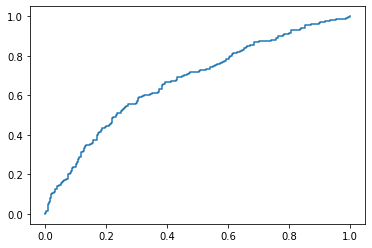

In [31]:
y_hat_train = logisticRegr.predict(X_train)
y_hat_test = logisticRegr.predict(X_test)
cm_train = confusion_matrix(y_train, y_hat_train)
cm_test = confusion_matrix(y_test, y_hat_test)

print(classification_report(y_train, y_hat_train))
print(classification_report(y_test, y_hat_test))
print("Confusion Matrix:")
print(cm_train)
print(cm_test)
plt.figure(1)
y_pred_prob = logisticRegr.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr_grd,tpr_grd)
auc(fpr_grd,tpr_grd)

### Next try Random Forest 
since it is efficient, not too sensitive to imbalanced data, and gives good insight about the feature importance.

In [32]:
rf = RandomForestClassifier(random_state=2)
rf.fit(X_train, np.array(y_train))
rf.score(X_test,y_test)

0.7745454545454545

              precision    recall  f1-score   support

           0       0.70      0.49      0.58       259
           1       0.79      0.91      0.85       566

    accuracy                           0.77       825
   macro avg       0.75      0.70      0.71       825
weighted avg       0.77      0.77      0.76       825

Confusion Matrix:
[[ 539    0]
 [   0 1136]]
[[126 133]
 [ 53 513]]


0.7963388678936382

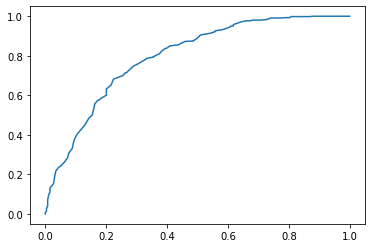

In [33]:
y_hat_train = rf.predict(X_train)
y_hat_test = rf.predict(X_test)
cm_train = confusion_matrix(y_train, y_hat_train)
cm_test = confusion_matrix(y_test, y_hat_test)

print(classification_report(y_test, y_hat_test))
print("Confusion Matrix:")
print(cm_train)
print(cm_test)

plt.figure(1)
y_pred_prob = rf.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr_grd,tpr_grd)
auc(fpr_grd,tpr_grd)

Feature ranking:
1. feature 19 (0.092262)
2. feature 3 (0.078531)
3. feature 20 (0.078199)
4. feature 5 (0.064780)
5. feature 31 (0.058572)
6. feature 6 (0.051489)
7. feature 23 (0.045891)
8. feature 22 (0.038476)
9. feature 28 (0.038153)
10. feature 26 (0.037604)
11. feature 30 (0.033648)
12. feature 24 (0.032618)
13. feature 21 (0.031907)
14. feature 17 (0.029350)
15. feature 27 (0.028584)
16. feature 25 (0.027869)
17. feature 1 (0.025657)
18. feature 29 (0.025030)
19. feature 18 (0.021784)
20. feature 7 (0.021312)
21. feature 4 (0.021123)
22. feature 2 (0.019721)
23. feature 11 (0.019309)
24. feature 0 (0.013578)
25. feature 8 (0.011597)
26. feature 12 (0.011007)
27. feature 9 (0.010649)
28. feature 10 (0.010529)
29. feature 14 (0.010402)
30. feature 13 (0.010371)
31. feature 16 (0.000000)
32. feature 15 (0.000000)


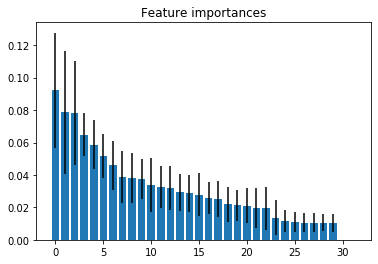

In [10]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], yerr=std[indices])
plt.show()

In [34]:
xgb = XGBClassifier(random_state=2)
xgb.fit(X_train, np.array(y_train))
xgb.score(X_test,y_test)

0.7284848484848485

              precision    recall  f1-score   support

           0       0.59      0.42      0.50       259
           1       0.77      0.87      0.81       566

    accuracy                           0.73       825
   macro avg       0.68      0.65      0.65       825
weighted avg       0.71      0.73      0.71       825

Confusion Matrix:
[[ 331  208]
 [  63 1073]]
[[110 149]
 [ 75 491]]


0.7540281321200049

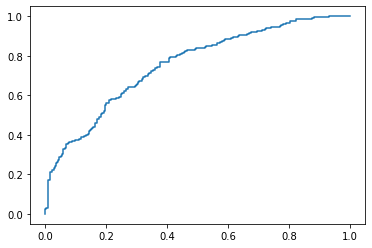

In [35]:
y_hat_train = xgb.predict(X_train)
y_hat_test = xgb.predict(X_test)
cm_train = confusion_matrix(y_train, y_hat_train)
cm_test = confusion_matrix(y_test, y_hat_test)

print(classification_report(y_test, y_hat_test))
print("Confusion Matrix:")
print(cm_train)
print(cm_test)

plt.figure(1)
y_pred_prob = xgb.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr_grd,tpr_grd)
auc(fpr_grd,tpr_grd)

Hyper parameter tuning using grid search cv

In [14]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)

In [15]:
 parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)
grid_search.fit(X_train, y_train)

In [16]:
grid_search.best_estimator_

In [17]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=180, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)
xgb.fit(X_train, np.array(y_train))
xgb.score(X_test,y_test)

0.7806060606060606

              precision    recall  f1-score   support

           0       0.67      0.58      0.63       259
           1       0.82      0.87      0.84       566

    accuracy                           0.78       825
   macro avg       0.75      0.73      0.74       825
weighted avg       0.77      0.78      0.78       825

Confusion Matrix:
[[ 539    0]
 [   0 1136]]
[[151 108]
 [ 73 493]]


0.8190649003369852

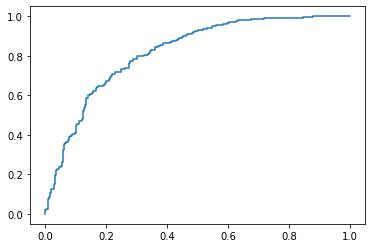

In [28]:
y_hat_train = xgb.predict(X_train)
y_hat_test = xgb.predict(X_test)
cm_train = confusion_matrix(y_train, y_hat_train)
cm_test = confusion_matrix(y_test, y_hat_test)

print(classification_report(y_test, y_hat_test))
print("Confusion Matrix:")
print(cm_train)
print(cm_test)

plt.figure(1)
y_pred_prob = xgb.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr_grd,tpr_grd)
auc(fpr_grd,tpr_grd)

In [25]:
# Save model to pickle file
pkl_filename = "Carters.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(xgb, file)